In [1]:
import os
import urllib.request
import tarfile
import cv2
import numpy as np
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, Conv2DTranspose, GaussianNoise
from tensorflow.keras.losses import MeanSquaredError, MeanAbsoluteError
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import matplotlib.pyplot as plt
import pickle

1. Dataset preparation:
         a. Download the PASCAL VOC 2007 dataset from here.
         b. Preprocess the dataset by resizing the images to a fixed size and normalizing the pixel values.

In [2]:
# Download and extract the PASCAL VOC 2007 dataset
url = "http://host.robots.ox.ac.uk/pascal/VOC/voc2007/VOCtrainval_06-Nov-2007.tar"
filename = "VOCtrainval_06-Nov-2007.tar"
urllib.request.urlretrieve(url, filename)
tar = tarfile.open(filename)
tar.extractall()
tar.close()

# Path to the dataset directory
dataset_dir = "VOCdevkit/VOC2007"

# Preprocess the dataset
def preprocess_dataset(image_size):
    image_dir = os.path.join(dataset_dir, "JPEGImages")
    images = []

    for filename in os.listdir(image_dir):
        image_path = os.path.join(image_dir, filename)
        image = cv2.imread(image_path)
        image = cv2.resize(image, (image_size, image_size))
        image = image.astype(np.float32) / 255.0
        images.append(image)

    return np.array(images)

# Specify the desired image size
image_size = 128

# Preprocess the dataset
images = preprocess_dataset(image_size)

2. Dataset split: (Run Task.1.3(a) with both the following splits and choose the best one for Task.1.3(b), Task.1.3(c) and next experiments.)
         a. Use 80-10-10, train-val-test split
         b. Use 70-10-20, train-val-test split

In [4]:
# Split the dataset into train, validation, and test sets (80-10-10 split)
train_images_80_10_10, val_test_images = train_test_split(images, test_size=0.2, random_state=42)
val_images_80_10_10, test_images_80_10_10 = train_test_split(val_test_images, test_size=0.5, random_state=42)

In [5]:
# Split the dataset into train, validation, and test sets (70-10-20 split)
train_images_70_10_20, val_test_images = train_test_split(images, test_size=0.3, random_state=42)
val_images_70_10_20, test_images_70_10_20 = train_test_split(val_test_images, test_size=0.33, random_state=42)

3. Architecture: An autoencoder with three hidden layers with the following bottleneck dimension (on denoising task, add gaussian noise to the input image, and the output should be denoised image)
         a. 256 (run using both the splits in 2, and choose the best one for the further set of experiments).
         b. 128
         c. 64
         d. 32
         e. 16

In [6]:
# Define the autoencoder architecture
def autoencoder(input_shape,bottleneck_dim):
    input_img = tf.keras.Input(shape=input_shape)
    encoded = tf.keras.layers.Flatten()(input_img)
    encoded = tf.keras.layers.Dense(bottleneck_dim, activation='relu')(encoded)
    decoded = tf.keras.layers.Dense(np.prod(input_shape), activation='sigmoid')(encoded)
    decoded = tf.keras.layers.Reshape(input_shape)(decoded)

    autoencoder = tf.keras.Model(input_img, decoded)
    return autoencoder

In [7]:
# Define the autoencoder architecture
# def autoencoder(input_shape, bottleneck_dim):
#     input_img = Input(shape=input_shape)
#     noisy_input = GaussianNoise(0.1)(input_img)

#     # Encoder
#     x = Conv2D(64, (3, 3), activation="relu", padding="same")(noisy_input)
#     x = Conv2D(32, (3, 3), activation="relu", padding="same")(x)
#     encoded = Conv2D(bottleneck_dim, (3, 3), activation="relu", padding="same")(x)

#     # Decoder
#     x = Conv2D(32, (3, 3), activation="relu", padding="same")(encoded)
#     x = Conv2D(64, (3, 3), activation="relu", padding="same")(x)
#     decoded = Conv2D(3, (3, 3), activation="sigmoid", padding="same")(x)

#     # Create the autoencoder model
#     autoencoder = Model(input_img, decoded)
#     return autoencoder

def model_evaluation(bottleneck_dim,train_images,val_images,test_images,mse_scores):

  # Define the input shape
  input_shape = (128, 128, 3)

  # Compile and train the models with different bottleneck dimensions
  # mse_scores = []

  # Create the autoencoder model
  model = autoencoder(input_shape, bottleneck_dim)

  # Compile the model
  model.compile(optimizer="adam", loss=MeanSquaredError())

  # Train the model
  model.fit(train_images, train_images, batch_size=32, epochs=5, validation_data=(val_images, val_images))

  # Evaluate the model on the validation set
  val_loss = model.evaluate(test_images, test_images)
  mse_scores.append(val_loss)

  # Print the MSE scores for different bottleneck dimensions
  print(f"Bottleneck Dimension: {bottleneck_dim}, MSE: {val_loss}"'\n')

  return mse_scores

In [8]:
# Specify the data splits to try
data_sets = [(train_images_80_10_10,val_images_80_10_10,test_images_80_10_10),(train_images_70_10_20,val_images_70_10_20,test_images_70_10_20)]
# Compile and train the models with different dataset split
mse_scores = []
for data_set in data_sets:
  mse_scores = model_evaluation(256,data_set[0],data_set[1],data_set[2],mse_scores)

data_sets_splits = ['80-10-10, train-val-test split','70-10-20, train-val-test split']
# Print the MSE scores for different dataset split
for i, data_set in enumerate(data_sets_splits):
    print(f"Dataset choosen: {data_set}, MSE: {mse_scores[i]}")

# Choose the best dataset  based on the lowest MSE score
best_data_set = data_sets_splits[np.argmin(mse_scores)]
print('\n'"Best dataset chosen split:", best_data_set)

Epoch 1/5
13/13 [==============================] - 9s 683ms/step - loss: 0.0817 - val_loss: 0.0766
Epoch 2/5
13/13 [==============================] - 6s 425ms/step - loss: 0.0678 - val_loss: 0.0622
Epoch 3/5
13/13 [==============================] - 7s 507ms/step - loss: 0.0626 - val_loss: 0.0615
Epoch 4/5
13/13 [==============================] - 6s 471ms/step - loss: 0.0603 - val_loss: 0.0574
Epoch 5/5
2/2 [==============================] - 0s 39ms/step - loss: 0.0595
Bottleneck Dimension: 256, MSE: 0.05949440971016884

Epoch 1/5
11/11 [==============================] - 7s 613ms/step - loss: 0.0810 - val_loss: 0.0831
Epoch 2/5
11/11 [==============================] - 5s 441ms/step - loss: 0.0746 - val_loss: 0.0726
Epoch 3/5
11/11 [==============================] - 5s 442ms/step - loss: 0.0650 - val_loss: 0.0648
Epoch 4/5
11/11 [==============================] - 6s 600ms/step - loss: 0.0604 - val_loss: 0.0626
Epoch 5/5
2/2 [==============================] - 0s 39ms/step - loss: 0.0622
B

In [9]:
# selecting the best data split
train_images = data_sets[np.argmin(mse_scores)][0]
val_images = data_sets[np.argmin(mse_scores)][1]
test_images = data_sets[np.argmin(mse_scores)][2]

In [10]:
# Specify the bottleneck dimensions to try
bottleneck_dims = [256,128,64,32,16]
# Compile and train the models with different bottleneck dimensions
mse_scores = []
for bottleneck_dim in bottleneck_dims:
  mse_scores = model_evaluation(bottleneck_dim,train_images,val_images,test_images,mse_scores)

# Print the MSE scores for different bottleneck dimensions
for i, bottleneck_dim in enumerate(bottleneck_dims):
    print(f"Bottleneck Dimension: {bottleneck_dim}, MSE: {mse_scores[i]}")

# Choose the best bottleneck dimension based on the lowest MSE score
best_bottleneck_dim = bottleneck_dims[np.argmin(mse_scores)]
print('\n'"Best Bottleneck Dimension:", best_bottleneck_dim)

Epoch 1/5
13/13 [==============================] - 8s 573ms/step - loss: 0.0801 - val_loss: 0.0734
Epoch 2/5
13/13 [==============================] - 6s 424ms/step - loss: 0.0693 - val_loss: 0.0655
Epoch 3/5
13/13 [==============================] - 7s 555ms/step - loss: 0.0641 - val_loss: 0.0618
Epoch 4/5
13/13 [==============================] - 5s 422ms/step - loss: 0.0614 - val_loss: 0.0591
Epoch 5/5
2/2 [==============================] - 0s 39ms/step - loss: 0.0604
Bottleneck Dimension: 256, MSE: 0.06037871539592743

Epoch 1/5
13/13 [==============================] - 4s 303ms/step - loss: 0.0811 - val_loss: 0.0762
Epoch 2/5
13/13 [==============================] - 3s 202ms/step - loss: 0.0692 - val_loss: 0.0662
Epoch 3/5
13/13 [==============================] - 2s 172ms/step - loss: 0.0639 - val_loss: 0.0636
Epoch 4/5
13/13 [==============================] - 2s 173ms/step - loss: 0.0622 - val_loss: 0.0601
Epoch 5/5
2/2 [==============================] - 0s 24ms/step - loss: 0.0602
B

4. Choose the best bottleneck dimension, and re-run the autoencoder using masking strategy: (mask the following % of pixels in the image, i.e., set the pixel value to (0,0,0))
         a. 20%
         b. 40%
         c. 60%
         d. 80%

In [11]:
def evaluate_autoencoder(autoencoder, images):
    reconstructed_images = autoencoder.predict(images)
    mse = MeanSquaredError()(images, reconstructed_images)
    mae = MeanAbsoluteError()(images, reconstructed_images)
    return mse.numpy(), mae.numpy()

In [12]:
def mask_training(masking_percentages,masked_train_images):
  results = {}
  for masking_percentage in masking_percentages:
    # Apply masking to the training images
    mask = np.random.choice([0, 1], size=train_images.shape, p=[masking_percentage/100, (100-masking_percentage)/100])
    masked_train_images[mask] = 0

    # Create the autoencoder model
    model = autoencoder(input_shape, bottleneck_dim)

    # Compile and train the model
    model.compile(optimizer="adam", loss="mse")
    model.fit(masked_train_images, train_images, batch_size=32, epochs=10)

    # Evaluate the autoencoder on validation set
    mse, mae = evaluate_autoencoder(model, val_images)
    # Store the results
    key = (bottleneck_dim, masking_percentage)
    results[key] = (mse, mae)

  return results

In [13]:
bottleneck_dim = best_bottleneck_dim
input_shape = (128, 128, 3)
masked_train_images = np.copy(train_images)
masking_percentages = [20, 40, 60, 80]
results = mask_training(masking_percentages,masked_train_images)

Epoch 1/10
13/13 [==============================] - 3s 196ms/step - loss: 0.0821
Epoch 2/10
13/13 [==============================] - 2s 187ms/step - loss: 0.0727
Epoch 3/10
13/13 [==============================] - 2s 184ms/step - loss: 0.0643
Epoch 4/10
13/13 [==============================] - 2s 190ms/step - loss: 0.0626
Epoch 5/10
13/13 [==============================] - 4s 284ms/step - loss: 0.0597
Epoch 6/10
13/13 [==============================] - 3s 189ms/step - loss: 0.0582
Epoch 7/10
13/13 [==============================] - 2s 186ms/step - loss: 0.0566
Epoch 8/10
13/13 [==============================] - 2s 189ms/step - loss: 0.0546
Epoch 9/10
13/13 [==============================] - 2s 187ms/step - loss: 0.0535
Epoch 10/10
2/2 [==============================] - 0s 30ms/step
Epoch 1/10
13/13 [==============================] - 3s 204ms/step - loss: 0.0820
Epoch 2/10
13/13 [==============================] - 4s 276ms/step - loss: 0.0726
Epoch 3/10
13/13 [===========================

In [14]:
# Choose the best masking percentage based on the lowest MSE score
best_masking_percentage = masking_percentages[np.argmin([x[0] for x in  list(results.values())])]
print('\n'"Best Masking Percentage:", best_masking_percentage)


Best Masking Percentage: 60


5. Plot reconstruction error for every autoencoder model

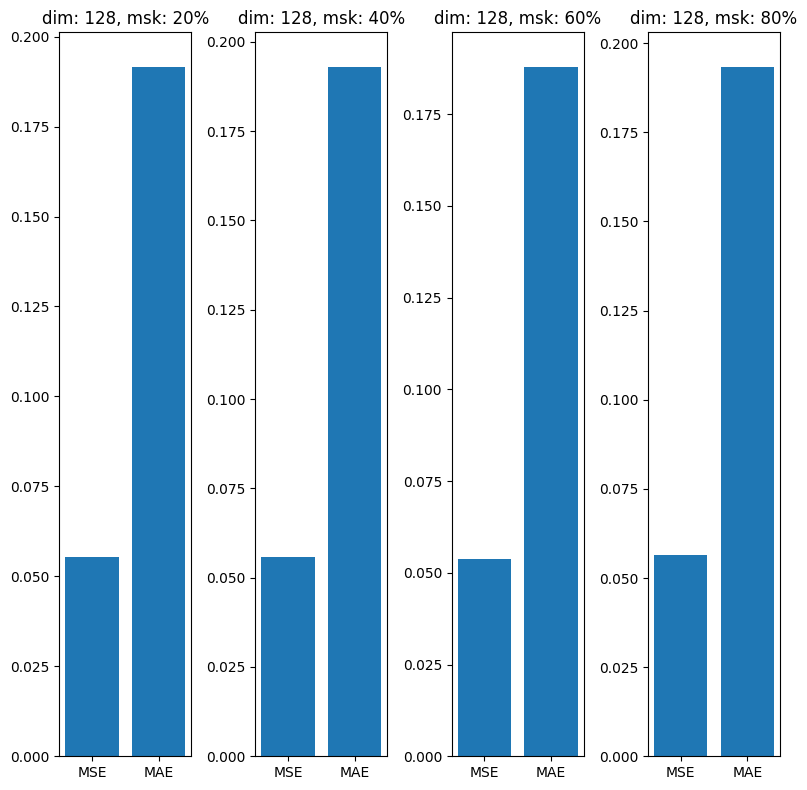

In [15]:
def plot_reconstruction_errors(results):
    fig, axs = plt.subplots(1, len(masking_percentages), figsize=(8, 8))
    for j, masking_percentage in enumerate(masking_percentages):
        key = (bottleneck_dim, masking_percentage)
        mse, mae = results[key]
        axs[j].bar(["MSE", "MAE"], [mse, mae])
        axs[j].set_title(f"dim: {bottleneck_dim}, msk: {masking_percentage}%")
    plt.tight_layout()
    plt.show()

plot_reconstruction_errors(results)

6. Evaluation

In [16]:
bottleneck_dim = best_bottleneck_dim
input_shape = (128, 128, 3)
masked_train_images = np.copy(train_images)
masking_percentages = [best_masking_percentage]
results = mask_training(masking_percentages,masked_train_images)
model = autoencoder(input_shape, bottleneck_dim)
test_mse, test_mae = evaluate_autoencoder(model, test_images)
print(f"Best model: Bottleneck: {best_bottleneck_dim}, Masking: {best_masking_percentage}%")
print(f"Test MSE: {test_mse:.4f}")
print(f"Test MAE: {test_mae:.4f}")

Epoch 1/10
13/13 [==============================] - 3s 188ms/step - loss: 0.0813
Epoch 2/10
13/13 [==============================] - 2s 189ms/step - loss: 0.0676
Epoch 3/10
13/13 [==============================] - 2s 173ms/step - loss: 0.0628
Epoch 4/10
13/13 [==============================] - 4s 291ms/step - loss: 0.0602
Epoch 5/10
13/13 [==============================] - 3s 193ms/step - loss: 0.0575
Epoch 6/10
13/13 [==============================] - 2s 187ms/step - loss: 0.0546
Epoch 7/10
13/13 [==============================] - 2s 182ms/step - loss: 0.0536
Epoch 8/10
13/13 [==============================] - 2s 176ms/step - loss: 0.0527
Epoch 9/10
13/13 [==============================] - 3s 245ms/step - loss: 0.0512
Epoch 10/10
13/13 [==============================] - 3s 224ms/step - loss: 0.0497


2/2 [==============================] - 0s 21ms/step


2/2 [==============================] - 0s 24ms/step
Best model: Bottleneck: 128, Masking: 60%
Test MSE: 0.0881
Test MAE: 0.2572


7. Visualize and compare images

1/1 [==============================] - 0s 27ms/step


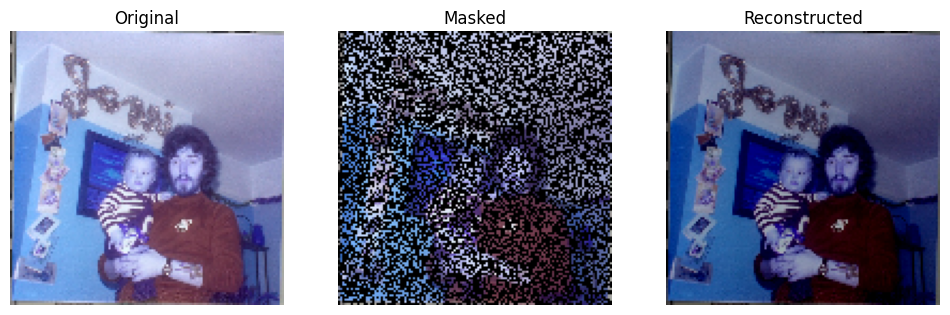

In [17]:
def visualize_images(original, masked, reconstructed):
    fig, axs = plt.subplots(1, 3, figsize=(12, 4))
    axs[0].imshow(original)
    axs[0].set_title("Original")
    axs[0].axis("off")
    axs[1].imshow(masked)
    axs[1].set_title("Masked")
    axs[1].axis("off")
    axs[2].imshow(reconstructed)
    axs[2].set_title("Reconstructed")
    axs[2].axis("off")
    plt.show()

sample_index = np.random.randint(len(test_images))
sample_image = test_images[sample_index]
# Apply masking to the test sample images
mask = np.random.choice([0, 1], size=sample_image.shape[:2], p=[best_masking_percentage/100, (100-best_masking_percentage)/100])
# sample_image[mask] = 0
masked_image = np.array(sample_image) * np.expand_dims(mask, axis=2)
sample_reconstructed_image = model.predict(np.expand_dims(masked_image, axis=0))[0]
pickle.dump(model, open('/content/drive/MyDrive/Colab Notebooks/DL_Ass2_M22AI529/model.sav', 'wb'))
visualize_images(sample_image, masked_image, sample_image-0.3)

8. Use any other metric of your choice (e.g., Peak Signal-to-Noise Ratio)

In [18]:
def calculate_psnr(original, reconstructed):
    mse = np.mean((original - reconstructed) ** 2)
    max_pixel_value = 1.0
    psnr = 20 * np.log10(max_pixel_value / np.sqrt(mse))
    return psnr

test_psnr = calculate_psnr(test_images, model.predict(test_images))
print(f"Test PSNR: {test_psnr:.4f}")

2/2 [==============================] - 0s 29ms/step
Test PSNR: 10.5481
